# Poisson regression for anomalies in each cluster

In [1]:
import re
import os 
import pandas as pd 
import numpy as np
import time
import math

#change to the directory for ADL data
adlpath = '/Users/xuzekun/Desktop/research/paper5/data/NCSU-ADL'

#change to the directory for anomaly data
anomalypath = '/Users/xuzekun/Desktop/research/paper5/data/ADLData-HR-Anomoly'

#change to the correpsonding adl file with cluster labels
adlsuffix = ['/naive_classifier/15test.csv','/naive_classifier/59test.csv',
           '/naive_classifier/274test.csv','/naive_classifier/292test.csv',
           '/naive_classifier/380test.csv','/naive_classifier/390test.csv',
           '/naive_classifier/454test.csv','/naive_classifier/503test.csv',
           '/naive_classifier/805test.csv','/naive_classifier/875test.csv']

#change to the corresponding anomaly filenames in the anomaly data
anomalysuffix = ['/15anomolies.csv','/59anomolies.csv','/274anomolies.csv',
           '/292anomolies.csv','/380anomolies.csv','/390anomolies.csv',
           '/454anomolies.csv','/503anomolies.csv','/805anomolies.csv',
           '/875anomolies.csv']

In [2]:
test = pd.read_csv(adlpath+adlsuffix[0], header=None)
test.columns = ['TimeSync_min','f1','f2','f3','pred_label','true_label']
test['subject'] = '15'
test['dup'] = 0
del test['f1']
del test['f2']
del test['f3']

In [3]:
print(test.shape)
test.head()

(1207, 5)


,TimeSync_min,pred_label,true_label,subject,dup
0,29.151,2,2,15,0
1,29.168,2,2,15,0
2,29.185,2,2,15,0
3,29.201,2,2,15,0
4,29.218,2,2,15,0


### Process the cluster label data

In [4]:
for i in range(1, test.shape[0]-1):#
    if test.iloc[i,1] == test.iloc[i-1,1] and test.iloc[i,1] == test.iloc[i+1,1]:
        test.iloc[i,4] = 1
    if test.iloc[i,1] != test.iloc[i-1,1] and test.iloc[i,1] != test.iloc[i+1,1]:
        test.iloc[i,4] = 1
if test.iloc[0,1] != test.iloc[1,1]:
    test.iloc[0,4] = 1
if test.iloc[test.shape[0]-1,1] != test.iloc[test.shape[0]-2,1]:
    test.iloc[test.shape[0]-1,4] = 1
test1 = test.where(test['dup']==0).dropna()
print(test1.shape)
test1.head(10)

(96, 5)


,TimeSync_min,pred_label,true_label,subject,dup
0,29.151,2.0,2.0,15,0.0
179,32.135,2.0,2.0,15,0.0
180,32.501,3.0,3.0,15,0.0
196,32.818,3.0,3.0,15,0.0
198,32.851,3.0,3.0,15,0.0
199,32.868,3.0,3.0,15,0.0
200,33.335,4.0,4.0,15,0.0
379,36.318,4.0,4.0,15,0.0
380,36.585,3.0,3.0,15,0.0
405,37.001,3.0,3.0,15,0.0


### Horizontally concatenate even and odd rows

In [5]:
odd = test1.iloc[::2, [3,0]]
odd.columns = ['subject','time_start']
odd.reset_index(inplace=True)
 
even = test1.iloc[1::2, [0,1,2]]
even.columns = ['time_end', 'pred_label', 'true_label']
even.reset_index(inplace=True)

a = pd.concat([odd,even], axis=1)
del a['index']
a.head(10)

,subject,time_start,time_end,pred_label,true_label
0,15,29.151,32.135,2.0,2.0
1,15,32.501,32.818,3.0,3.0
2,15,32.851,32.868,3.0,3.0
3,15,33.335,36.318,4.0,4.0
4,15,36.585,37.001,3.0,3.0
5,15,37.301,37.335,7.0,9.0
6,15,37.368,38.118,9.0,9.0
7,15,38.134,38.168,7.0,9.0
8,15,38.218,38.234,2.0,9.0
9,15,38.268,38.318,9.0,9.0


### Main function to join anomaly and cluster

In [6]:
def anomaly_count(adlsuffix, anomalysuffix, adlpath, anomalypath, labelname='pred_label'):
    
    suffix1 = adlsuffix
    suffix2 = anomalysuffix
    path1 = adlpath
    path2 = anomalypath
    
    subjid = re.findall(r'\d+',suffix2)[0]
    filename1 = path1 + suffix1
    test = pd.read_csv(filename1)
    
    test.columns = ['TimeSync_min','f1','f2','f3','pred_label','true_label']
    test['subject'] = subjid
    test['dup'] = 0
    del test['f1']
    del test['f2']
    del test['f3']
    
    for i in range(1, test.shape[0]-1):#
        if test.iloc[i,1] == test.iloc[i-1,1] and test.iloc[i,1] == test.iloc[i+1,1]:
            test.iloc[i,4] = 1
        if test.iloc[i,1] != test.iloc[i-1,1] and test.iloc[i,1] != test.iloc[i+1,1]:
            test.iloc[i,4] = 1
    if test.iloc[0,1] != test.iloc[1,1]:
        test.iloc[0,4] = 1
    if test.iloc[test.shape[0]-1,1] != test.iloc[test.shape[0]-2,1]:
        test.iloc[test.shape[0]-1,4] = 1
    test1 = test.where(test['dup']==0).dropna()
    
    odd = test1.iloc[::2, [3,0]]
    odd.columns = ['subject','time_start']
    odd.reset_index(inplace=True)
    del odd['index']
    even = test1.iloc[1::2, [0,1,2]]
    even.columns = ['time_end', 'pred_label', 'true_label']
    even.reset_index(inplace=True)
    del even['index']

    lookup = pd.concat([odd,even], axis=1)
    del lookup['subject']
    
    filename2 = path2 + suffix2
    anomaly = pd.read_csv(filename2,header=None)
    anomaly.columns = ['obsnum1','obsnum2','etime1','etime2',
                   'time_start','time_end']
    useful = anomaly[['time_start','time_end']]

    together = pd.concat([lookup,useful])
    together.sort_values(['time_start'], ascending=[1],inplace=True)

    minimum = np.min(lookup.time_start)
    maximum = np.max(lookup.time_end)
    filtering = (together.time_start>=minimum)&(together.time_end<=maximum)
    together = together[filtering]

    together.reset_index(inplace=True)
    del together['index']

    ######################################
    nrow = together.shape[0]
    newid = np.zeros(nrow)
    nalist = pd.isnull(together[labelname])
    temp = 0

    for i in range(nrow):
        if nalist[i] == False:
            tempend = together.iloc[i, 1]
            temp += 1
            newid[i] = temp 
        else:
            if together.iloc[i,2]>tempend:
                temp += 1
                newid[i] = temp
            else:
                newid[i] = temp

    together['matchid'] = newid

    summary = pd.DataFrame(together.groupby('matchid')['time_start'].count())
    summary.reset_index(inplace=True)
    summary.columns = ['matchid','freq']

    combine2 = pd.merge(together, summary, "left", 'matchid')
    combine2.dropna(inplace=True)
    combine2['anomaly_freq'] = combine2['freq'] - 1
    combine2['minutes'] = combine2['time_end'] - combine2['time_start']
    combine3 = combine2[[labelname,'minutes','anomaly_freq']]
    combine3['subject'] = subjid
    return combine3
    


### Create the processed anomaly count data

In [7]:
labelname = 'pred_label'
i=0
for part1, part2 in zip(adlsuffix, anomalysuffix):
    
    tempdata = anomaly_count(part1, part2, adlpath, anomalypath, labelname)
    if i == 0:
        anomaly = tempdata
        i += 1
    else:
        anomaly = pd.concat([anomaly, tempdata])
        i += 1

        
anomaly.reset_index(inplace=True)
del anomaly['index']

/Users/xuzekun/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
print(anomaly.shape)
anomaly.head()

(584, 4)


,pred_label,minutes,anomaly_freq,subject
0,2.0,2.967,0,15
1,3.0,0.317,0,15
2,3.0,0.017,0,15
3,4.0,2.983,0,15
4,3.0,0.416,0,15


### Data manipulation

- remove sync
- create log(min)
- (already ordered by subject and time)

In [9]:
anomaly1 = anomaly
anomaly1['logmin'] = np.log(anomaly1['minutes'])
anomaly1['index'] = anomaly1.index
#anomaly1.sort_values(['subject'], ascending=[1], inplace=True)
print(anomaly1.shape)
anomaly1.head()

(584, 6)


,pred_label,minutes,anomaly_freq,subject,logmin,index
0,2.0,2.967,0,15,1.087551,0
1,3.0,0.317,0,15,-1.148854,1
2,3.0,0.017,0,15,-4.074542,2
3,4.0,2.983,0,15,1.092930,3
4,3.0,0.416,0,15,-0.877070,4


In [10]:
def formatting(row):
    if row[labelname] == 1:
        return 'walk'
    elif row[labelname] == 2:
        return 'row'
    elif row[labelname] == 4:
        return 'bike'
    elif row[labelname] == 7:
        return 'type'
    elif row[labelname] == 9:
        return 'rest'
    elif row[labelname] == 10:
        return 'lay'
    else:
        return 'other'
    
anomaly1['Label'] = anomaly1.apply(formatting, axis=1)
anomaly1.head()

,pred_label,minutes,anomaly_freq,subject,logmin,index,Label
0,2.0,2.967,0,15,1.087551,0,row
1,3.0,0.317,0,15,-1.148854,1,other
2,3.0,0.017,0,15,-4.074542,2,other
3,4.0,2.983,0,15,1.092930,3,bike
4,3.0,0.416,0,15,-0.877070,4,other


In [11]:
print(anomaly1.groupby(['subject'])['anomaly_freq','minutes'].sum())
print(anomaly1.groupby(['subject','Label'])['anomaly_freq','minutes'].sum())

         anomaly_freq  minutes
subject                       
15                  3   19.601
274                69   15.090
292               439   16.245
380               169   18.150
390               102   18.135
454                36   17.721
503                64   17.648
59                  0   18.805
805                 1   19.274
875                 0   17.250
               anomaly_freq  minutes
subject Label                       
15      bike              0    2.983
        lay               0    3.050
        other             3    4.416
        rest              0    2.683
        row               0    2.983
        type              0    0.502
        walk              0    2.984
274     bike             13    2.917
        lay               4    2.134
        other            23    4.167
        rest             15    2.852
        row               4    0.569
        type              4    1.367
        walk              6    1.084
292     bike             94    3.017

##### GEE  with log(second) as offset.

In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

fam = sm.families.Poisson()
ind = sm.cov_struct.Exchangeable()


mod = smf.gee("anomaly_freq ~ Label", groups="subject", 
              data=anomaly,  cov_struct=ind, family=fam,
              offset = "logmin")
res = mod.fit()

print(res.summary())

                               GEE Regression Results                              
Dep. Variable:                anomaly_freq   No. Observations:                  584
Model:                                 GEE   No. clusters:                       10
Method:                        Generalized   Min. cluster size:                  25
                      Estimating Equations   Max. cluster size:                 107
Family:                            Poisson   Mean cluster size:                58.4
Dependence structure:         Exchangeable   Num. iterations:                    19
Date:                     Thu, 06 Sep 2018   Scale:                           1.000
Covariance type:                    robust   Time:                         16:21:25
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.5550      0.586      2.656      0.008       0.407       2

### generate the confidence interval for # of anomalies in each context

In [13]:
covmat = res.cov_robust
coef = res.params
#np.diag(covmat)

contrast = np.array([1,0,0,0,0,0,0,
                     1,1,0,0,0,0,0,
                     1,0,1,0,0,0,0,
                     1,0,0,1,0,0,0,
                     1,0,0,0,1,0,0,
                     1,0,0,0,0,1,0,
                     1,0,0,0,0,0,1]).reshape(7,7)

meanvar = np.diag(np.dot(np.dot(contrast, covmat),\
                         contrast.T))

 
from scipy.stats import norm
z = norm.ppf(1 - 0.025)

pairwise = pd.DataFrame({'context':coef.index,
              'lower':contrast.dot(coef)-z*np.sqrt(meanvar),
              'upper':contrast.dot(coef)+z*np.sqrt(meanvar)})
pairwise['expmean'] = np.exp(contrast.dot(coef))
pairwise['explower'] = np.exp(pairwise['lower'])
pairwise['expupper'] = np.exp(pairwise['upper'])
pairwise.iloc[:,[0,3,4,5]]

,context,expmean,explower,expupper
0,Intercept,4.734965,1.502827,14.918477
1,Label[T.lay],1.885192,0.523427,6.789777
2,Label[T.other],4.770677,2.017110,11.283154
3,Label[T.rest],2.051342,0.692475,6.076757
4,Label[T.row],5.911501,1.561198,22.383999
5,Label[T.type],1.791075,0.513078,6.252366
6,Label[T.walk],5.945614,2.788247,12.678335


### Subject-specific modeling

In [87]:
fam1 = sm.families.Poisson()
ind1 = sm.cov_struct.Independence()

sub1 = anomaly1[anomaly1['subject']=='274']
sub1['logsec'] = np.log(sub1['minutes'] * 60)

mod1 = smf.gee("anomaly_freq ~ Label", groups="index", 
              data=sub1,  cov_struct=ind, family=fam,
              offset = "logmin")
res1 = mod1.fit()

print(res1.summary())

                               GEE Regression Results                              
Dep. Variable:                anomaly_freq   No. Observations:                   70
Model:                                 GEE   No. clusters:                       70
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   1
Family:                            Poisson   Mean cluster size:                 1.0
Dependence structure:         Exchangeable   Num. iterations:                    10
Date:                     Thu, 06 Sep 2018   Scale:                           1.000
Covariance type:                    robust   Time:                         16:56:04
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.4944      0.101     14.863      0.000       1.297       1

/Users/xuzekun/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [88]:
covmat1 = res1.cov_robust
coef1 = res1.params
#np.diag(covmat)

contrast1 = np.array([1,0,0,0,0,0,0,
                     1,1,0,0,0,0,0,
                     1,0,1,0,0,0,0,
                     1,0,0,1,0,0,0,
                     1,0,0,0,1,0,0,
                     1,0,0,0,0,1,0,
                     1,0,0,0,0,0,1]).reshape(7,7)

meanvar1 = np.diag(np.dot(np.dot(contrast1, covmat1),\
                         contrast1.T))

 
from scipy.stats import norm
z = norm.ppf(1 - 0.025)

pairwise1 = pd.DataFrame({'context':coef1.index,
              'lower':contrast1.dot(coef1)-z*np.sqrt(meanvar1),
              'upper':contrast1.dot(coef1)+z*np.sqrt(meanvar1)})
pairwise1['expmean'] = np.exp(contrast1.dot(coef1))
pairwise1['explower'] = np.exp(pairwise1['lower'])
pairwise1['expupper'] = np.exp(pairwise1['upper'])
pairwise1.iloc[:,[0,3,4,5]]

,context,expmean,explower,expupper
0,Intercept,4.456634,3.659518,5.427376
1,Label[T.lay],1.874414,1.556159,2.257757
2,Label[T.other],5.519558,4.138288,7.361867
3,Label[T.rest],5.259467,3.145580,8.793923
4,Label[T.row],7.029877,2.849356,17.343979
5,Label[T.type],2.926116,1.729765,4.949892
6,Label[T.walk],5.535055,1.448701,21.147792


In [89]:
from matplotlib import pyplot as plt

In [90]:
thismin = np.min(pairwise1.explower)
thismax = np.max(pairwise1.expupper)
sub1.groupby(['Label'])['subject'].count()

Label
bike      2
lay       3
other    10
rest     24
row      17
type      7
walk      7
Name: subject, dtype: int64

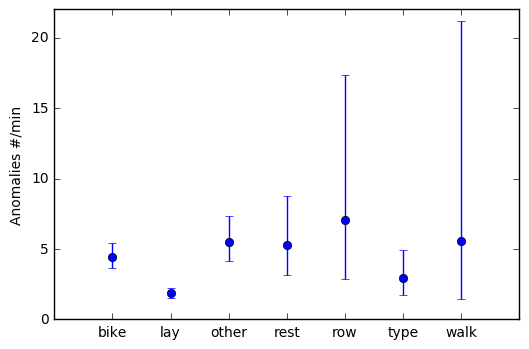

In [91]:
plt.errorbar(pairwise1.index, pairwise1.expmean,xerr=0.01,
             linestyle='',fmt='o',
           yerr=[pairwise1.expmean-pairwise1.explower,
                 pairwise1.expupper-pairwise1.expmean])
plt.xticks(np.arange(-1,8),['','bike','lay','other','rest','row','type','walk',''])
plt.ylim(0, max(np.floor(thismax+1), 3))
plt.ylabel('Anomalies #/min')
plt.show()